In [30]:
# Data Retrieval and Preprocessing
# Step 1: Install and Load Required Libraries
# Install and load the necessary packages for time series analysis
required_packages <- c("quantmod", "tidyverse", "lubridate", "tseries",
                       "forecast", "parallel", "RcppParallel", "foreach",
                       "doParallel", "iterators", "future")
new_packages <- required_packages[!(required_packages %in%
                                      installed.packages()[, "Package"])]
if (length(new_packages)) install.packages(new_packages)
suppressMessages(suppressWarnings(
  invisible(lapply(required_packages, library, character.only = TRUE))
))

In [31]:
# Step 2: Data Import and Initial Inspection
# Load S&P 500 Index data from Yahoo Finance
start_date <- as.Date("2000-01-01")
end_date <- as.Date("2023-12-31")

# Retrieve S&P 500 data
getSymbols("^GSPC", src = "yahoo", from = start_date, to = end_date)

# View the first few rows of the dataset
head(GSPC)

[1] "GSPC"

           GSPC.Open GSPC.High GSPC.Low GSPC.Close GSPC.Volume GSPC.Adjusted
2000-01-03   1469.25   1478.00  1438.36    1455.22   931800000       1455.22
2000-01-04   1455.22   1455.22  1397.43    1399.42  1009000000       1399.42
2000-01-05   1399.42   1413.27  1377.68    1402.11  1085500000       1402.11
2000-01-06   1402.11   1411.90  1392.10    1403.45  1092300000       1403.45
2000-01-07   1403.45   1441.47  1400.73    1441.47  1225200000       1441.47
2000-01-10   1441.47   1464.36  1441.47    1457.60  1064800000       1457.60

In [32]:
# Step 3: Data Inspection and Cleaning
# Summarize the dataset to check for missing values
summary(GSPC)

# Check for any missing values in the dataset
any_na <- any(is.na(GSPC))
cat("Are there any missing values? ", any_na, "\n")

# Interpolate missing values if any are found
if (any_na) {
  GSPC <- na.approx(GSPC) #nolint # Linearly interpolate missing values
  cat("Missing values have been interpolated.\n")
}

# Identify potential outliers using the Interquartile Range (IQR) method
q1 <- quantile(GSPC$GSPC.Adjusted, 0.25)
q3 <- quantile(GSPC$GSPC.Adjusted, 0.75)
iqr <- q3 - q1

# Define thresholds for outlier detection
lower_bound <- q1 - 1.5 * iqr
upper_bound <- q3 + 1.5 * iqr

# Filter potential outliers
potential_outliers <- GSPC$GSPC.Adjusted[GSPC$GSPC.Adjusted < lower_bound | GSPC$GSPC.Adjusted > upper_bound] # nolint
cat("Number of potential outliers detected: ", length(potential_outliers), "\n")

     Index              GSPC.Open        GSPC.High         GSPC.Low     
 Min.   :2000-01-03   Min.   : 679.3   Min.   : 695.3   Min.   : 666.8  
 1st Qu.:2006-01-04   1st Qu.:1191.4   1st Qu.:1198.7   1st Qu.:1184.4  
 Median :2011-12-30   Median :1457.2   Median :1465.7   Median :1448.4  
 Mean   :2012-01-02   Mean   :1973.3   Mean   :1985.0   Mean   :1960.8  
 3rd Qu.:2017-12-29   3rd Qu.:2581.9   3rd Qu.:2596.3   3rd Qu.:2572.2  
 Max.   :2023-12-29   Max.   :4804.5   Max.   :4818.6   Max.   :4781.0  
   GSPC.Close      GSPC.Volume        GSPC.Adjusted   
 Min.   : 676.5   Min.   :3.561e+08   Min.   : 676.5  
 1st Qu.:1191.4   1st Qu.:2.094e+09   1st Qu.:1191.4  
 Median :1457.3   Median :3.443e+09   Median :1457.3  
 Mean   :1973.6   Mean   :3.327e+09   Mean   :1973.6  
 3rd Qu.:2584.8   3rd Qu.:4.160e+09   3rd Qu.:2584.8  
 Max.   :4796.6   Max.   :1.146e+10   Max.   :4796.6  

Are there any missing values?  FALSE 
Number of potential outliers detected:  43 


In [33]:
# Step 4: Check Trading Day Continuity and Price Movements
# Verify continuity of trading days
trading_days <- index(GSPC)
gaps <- diff(trading_days)
suspicious_gaps <- which(gaps > 3)
if (length(suspicious_gaps) > 0) {
  cat("Warning: Unusual gaps in trading days detected.\n")
}

# Validate significant price movements
daily_returns <- diff(log(GSPC$GSPC.Adjusted))
suspicious_moves <- which(abs(daily_returns) > 0.1)
if (length(suspicious_moves) > 0) {
  cat("Warning: Large price movements detected.\n")
}

In [34]:
# Step 5: Outlier Analysis Around Key Events
outlier_analysis <- function(data, dates, threshold_dates) {
  # Define key events and windows for analysis
  key_events <- data.frame( # nolint
    date = threshold_dates,
    description = c("2008 Financial Crisis", "COVID-19 Pandemic"),
    window = c(30, 30)  # Days to check around each event
  )

  # Initialize outlier distribution data frame
  outlier_distribution <- data.frame( # nolint
    period = c("Pre-2008", "2008-Crisis", "Post-2008-Pre-COVID", "COVID-Period", "Post-COVID"), # nolint
    count = numeric(5),
    percentage = numeric(5)
  )

  # Output summary of outlier analysis
  cat("Outlier Analysis Summary:\n")
  cat(sprintf("Total outliers detected: %d\n", length(potential_outliers))) # nolint
  cat(sprintf("Percentage of total observations: %.2f%%\n",
              100 * length(potential_outliers) / length(data))) # nolint
}

# Perform outlier analysis around key events
outlier_analysis(GSPC$GSPC.Adjusted, index(GSPC), c("2008-09-15", "2020-02-19"))

Outlier Analysis Summary:
Total outliers detected: 43
Percentage of total observations: 0.71%


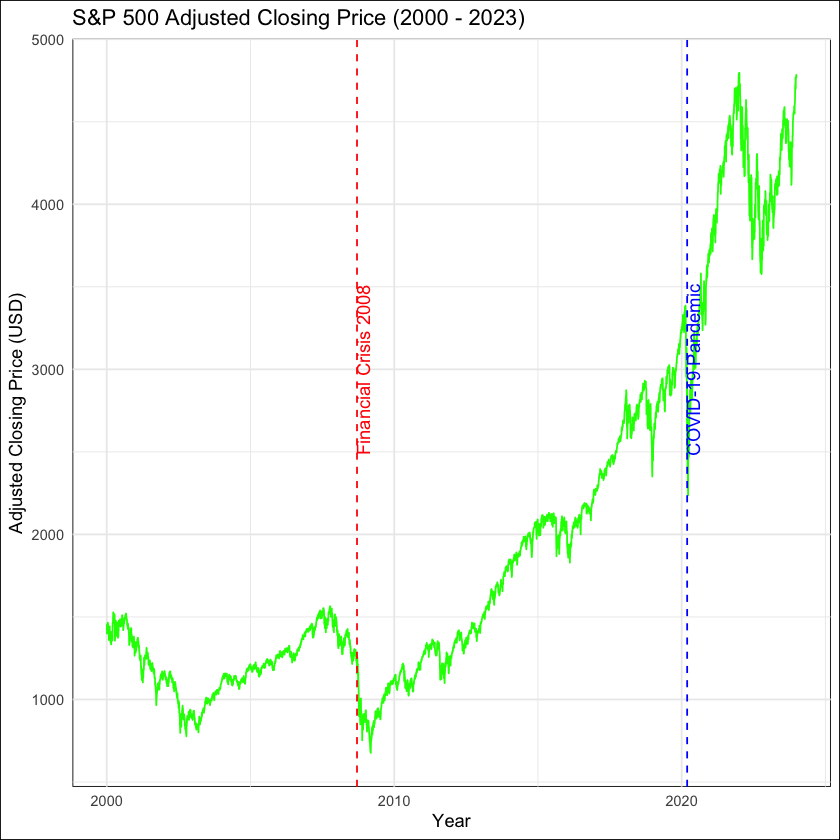

In [35]:
# Step 6: Visualization of the Time Series
# Extract the Adjusted Closing Prices for visualization
gspc_close <- GSPC[, "GSPC.Adjusted"]

# Plot the time series with annotations for key events
gspc_close %>%
  as_tibble(rownames = "Date") %>%
  mutate(Date = as.Date(Date)) %>%
  ggplot(aes(x = Date, y = GSPC.Adjusted)) +
  geom_line(color = "green") +
  geom_vline(xintercept = as.Date("2008-09-15"), linetype = "dashed", color = "red") + # nolint
  annotate("text", x = as.Date("2008-09-15"), y = 3000, label = "Financial Crisis 2008", # nolint
           color = "red", angle = 90, vjust = 1) +
  geom_vline(xintercept = as.Date("2020-03-11"), linetype = "dashed", color = "blue") + # nolint
  annotate("text", x = as.Date("2020-03-11"), y = 3000, label = "COVID-19 Pandemic", # nolint
           color = "blue", angle = 90, vjust = 1) +
  labs(title = "S&P 500 Adjusted Closing Price (2000 - 2023)",
       x = "Year",
       y = "Adjusted Closing Price (USD)") +
  theme_minimal() +
  theme(panel.background = element_rect(fill = "white"),
        plot.background = element_rect(fill = "white"))

# Save with specific dimensions
ggsave("../Reports/Images/Plot1.png", width = 12, height = 8, dpi = 300)

In [36]:
# Step 7: Summary Statistics of Adjusted Closing Price
summary_stats <- GSPC[, "GSPC.Adjusted"] %>%
  as_tibble(rownames = "Date") %>%
  summarise(
    Min = min(GSPC.Adjusted, na.rm = TRUE),
    Max = max(GSPC.Adjusted, na.rm = TRUE),
    Mean = mean(GSPC.Adjusted, na.rm = TRUE),
    Median = median(GSPC.Adjusted, na.rm = TRUE)
  )

print(summary_stats)

# A tibble: 1 x 4
    Min   Max  Mean Median
  <dbl> <dbl> <dbl>  <dbl>
1  677. 4797. 1974.  1457.


In [37]:
# Step 8: Check for Stationarity Using Augmented Dickey-Fuller Test
# Perform ADF test to check stationarity of the series
adf_result <- adf.test(GSPC$GSPC.Adjusted, alternative = "stationary")
cat("ADF Test p-value:", adf_result$p.value, "\n")

# Interpret the test result
if (adf_result$p.value > 0.05) {
  cat("The data is non-stationary. Transformation is required.\n")
} else {
  cat("The data is stationary.\n")
}

ADF Test p-value: 0.8347534 
The data is non-stationary. Transformation is required.


In [38]:
# Preliminary Analysis and Model Identification
# Step 1: Apply Log Transformation and Differencing if Non-Stationary
if (adf_result$p.value > 0.05) {
  # Apply log transformation to stabilize variance
  gspc_log <- log(GSPC$GSPC.Adjusted)

  # Plot the log-transformed series
  gspc_log %>%
    as_tibble(rownames = "Date") %>%
    mutate(Date = as.Date(Date)) %>%
    ggplot(aes(x = Date, y = value)) +
    geom_line(color = "darkblue") +
    labs(title = "Log-Transformed S&P 500 Adjusted Closing Price (2000 - 2023)",
         x = "Year",
         y = "Log Adjusted Closing Price") +
    theme_minimal()

  # Apply first-order differencing to achieve stationarity
  gspc_diff <- diff(gspc_log, differences = 1)

  # Remove NA values resulting from differencing
  gspc_diff <- gspc_diff[!is.na(gspc_diff)]

  # Plot the differenced series
  gspc_diff %>%
    as_tibble() %>%
    ggplot(aes(x = row_number(), y = value)) +
    geom_line(color = "purple") +
    labs(title = "Differenced Log-Transformed Series of S&P 500",
         x = "Observation Index",
         y = "Differenced Log Value") +
    theme_minimal()

  # Perform ADF test on the differenced series
  adf_diff_result <- adf.test(gspc_diff, alternative = "stationary")
  cat("ADF Test on Differenced Series p-value:", adf_diff_result$p.value, "\n")

  if (adf_diff_result$p.value < 0.05) {
    cat("The differenced log-transformed series is now stationary.\n")
  } else {
    cat("The data is still non-stationary. Further differencing may be required.\n") # nolint
  }
}

Warning message in adf.test(gspc_diff, alternative = "stationary"):
"p-value smaller than printed p-value"


ADF Test on Differenced Series p-value: 0.01 
The differenced log-transformed series is now stationary.


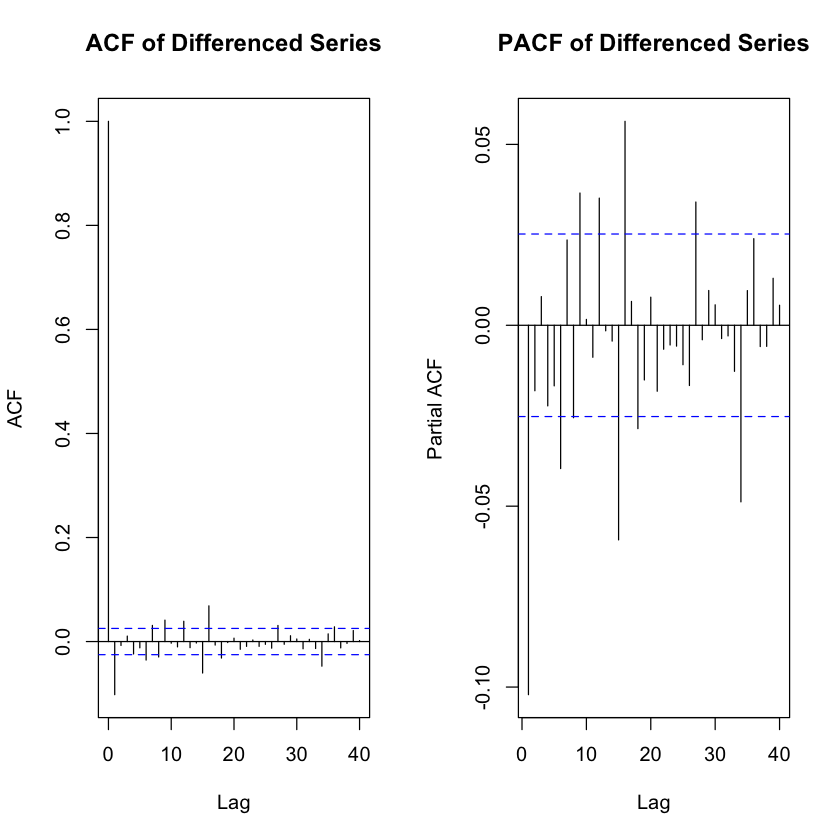

In [39]:
# Step 2: ACF and PACF Analysis for Model Identification
# Plot ACF and PACF to determine AR and MA components
# Create the directory if it doesn't exist
dir.create("../Reports/Images", recursive = TRUE, showWarnings = FALSE)

# First display the plot in notebook
par(bg = "white", mfrow = c(1, 2))
acf(gspc_diff, main = "ACF of Differenced Series", lag.max = 40)
pacf(gspc_diff, main = "PACF of Differenced Series", lag.max = 40)
par(mfrow = c(1, 1))

# Then save it to file
png("../Reports/Images/Plot2.png", width = 1200, height = 600, res = 150)
par(bg = "white", mfrow = c(1, 2))
acf(gspc_diff, main = "ACF of Differenced Series", lag.max = 40)
pacf(gspc_diff, main = "PACF of Differenced Series", lag.max = 40)
par(mfrow = c(1, 1))
invisible(dev.off())

In [40]:
# Step 3: Model Selection Using auto.arima()
# Utilize auto.arima() to suggest ARIMA model parameters
auto_model <- auto.arima(GSPC$GSPC.Adjusted, seasonal = FALSE)
print(auto_model)

# Display the ARIMA order selected by auto.arima()
best_order <- c(auto_model$arma[1], auto_model$arma[6], auto_model$arma[2])
cat("\nSelected ARIMA Order: p = ", best_order[1], ", d = ", best_order[2], ", q = ", best_order[3], "\n") # nolint

Series: GSPC$GSPC.Adjusted 
ARIMA(1,2,0) 

Coefficients:
          ar1
      -0.5575
s.e.   0.0107

sigma^2 = 959.8:  log likelihood = -29283.46
AIC=58570.92   AICc=58570.93   BIC=58584.33

Selected ARIMA Order: p =  1 , d =  2 , q =  0 


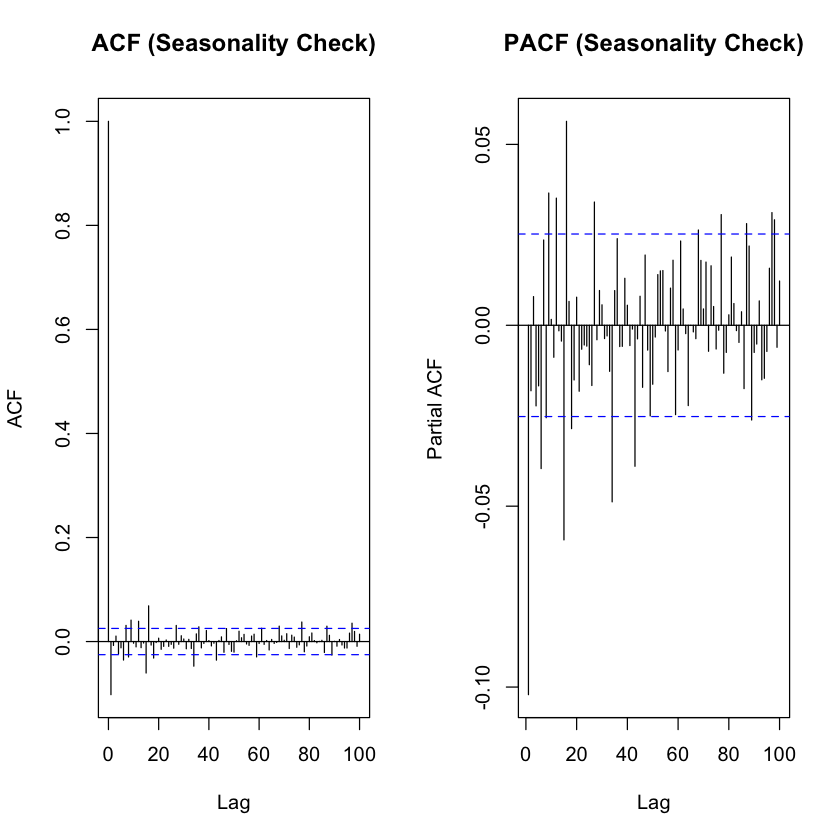

In [41]:
# Step 4: Check for Seasonal Elements in the Time Series
# Plot ACF and PACF with extended lags to detect seasonality

# First display the plots in notebook
par(bg = "white", mfrow = c(1, 2))
acf(gspc_diff, lag.max = 100, main = "ACF (Seasonality Check)")
pacf(gspc_diff, lag.max = 100, main = "PACF (Seasonality Check)")
par(mfrow = c(1, 1))

# Save plots to file
png("../Reports/Images/Plot3.png", width = 1200, height = 600, res = 150)
par(bg = "white", mfrow = c(1, 2))
acf(gspc_diff, lag.max = 100, main = "ACF (Seasonality Check)")
pacf(gspc_diff, lag.max = 100, main = "PACF (Seasonality Check)")
par(mfrow = c(1, 1))
invisible(dev.off())

In [42]:
# ARIMA Model Fitting and Comparison
# Step 1: Fit Multiple ARIMA Models and Compare
# Fit various ARIMA models based on preliminary analysis
model_1 <- Arima(GSPC$GSPC.Adjusted, order = c(1, 2, 0))
model_2 <- Arima(GSPC$GSPC.Adjusted, order = c(1, 1, 1))
model_3 <- Arima(GSPC$GSPC.Adjusted, order = c(2, 1, 2))

# Collect model summaries and performance metrics
models <- list(model_1, model_2, model_3)
model_names <- c("ARIMA (1,2,0)", "ARIMA (1,1,1)", "ARIMA (2,1,2)")

# Create a table of model metrics
model_metrics <- tibble(
  Model = model_names,
  AIC = sapply(models, AIC),
  BIC = sapply(models, BIC),
  RMSE = sapply(models, function(model) {
    residuals <- residuals(model)
    sqrt(mean(residuals^2))
  }),
  Sigma2 = sapply(models, function(model) {
    model$sigma2
  })
)

print(model_metrics)

# Identify the best model based on AIC
best_model_index <- which.min(model_metrics$AIC)
best_model_name <- model_metrics$Model[best_model_index]
cat("\nThe model with the lowest AIC is:", best_model_name, "\n")

# A tibble: 3 x 5
  Model            AIC    BIC  RMSE Sigma2
  <chr>          <dbl>  <dbl> <dbl>  <dbl>
1 ARIMA (1,2,0) 58571. 58584.  31.0   960.
2 ARIMA (1,1,1) 56067. 56088.  25.2   633.
3 ARIMA (2,1,2) 55940. 55974.  24.9   619.

The model with the lowest AIC is: ARIMA (2,1,2) 


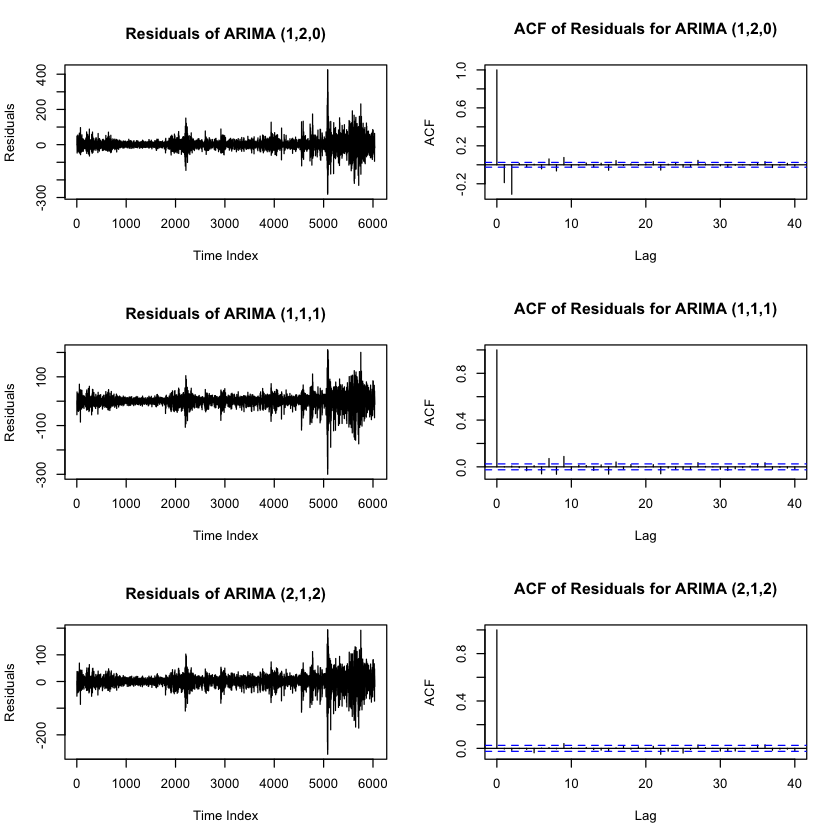

In [43]:
# Step 2: Visual Evaluation of Residuals for Each Model
# First display the plots in notebook
par(bg = "white", mfrow = c(3, 2))
for (i in seq_along(models)) {
  residuals <- residuals(models[[i]])
  plot(residuals, main = paste("Residuals of", model_names[i]),
       ylab = "Residuals", xlab = "Time Index")
  acf(residuals, main = paste("ACF of Residuals for", model_names[i]),
      lag.max = 40)
}
par(mfrow = c(1, 1))

# Save plots to file
png("../Reports/Images/Plot4.png", width = 1200, height = 1800, res = 150)
par(bg = "white", mfrow = c(3, 2))
for (i in seq_along(models)) {
  residuals <- residuals(models[[i]])
  plot(residuals, main = paste("Residuals of", model_names[i]),
       ylab = "Residuals", xlab = "Time Index")
  acf(residuals, main = paste("ACF of Residuals for", model_names[i]),
      lag.max = 40)
}
par(mfrow = c(1, 1))
invisible(dev.off())

In [44]:
# Step 3: Select the Best Model Based on Performance Metrics
# Find the model with the lowest AIC, BIC, and RMSE
best_model_index <- which.min(model_metrics$AIC)
best_model_name <- model_metrics$Model[best_model_index]
cat("The model with the lowest AIC is:", best_model_name, "\n")

# Select the best model for further diagnostics
best_model <- models[[best_model_index]]

The model with the lowest AIC is: ARIMA (2,1,2) 


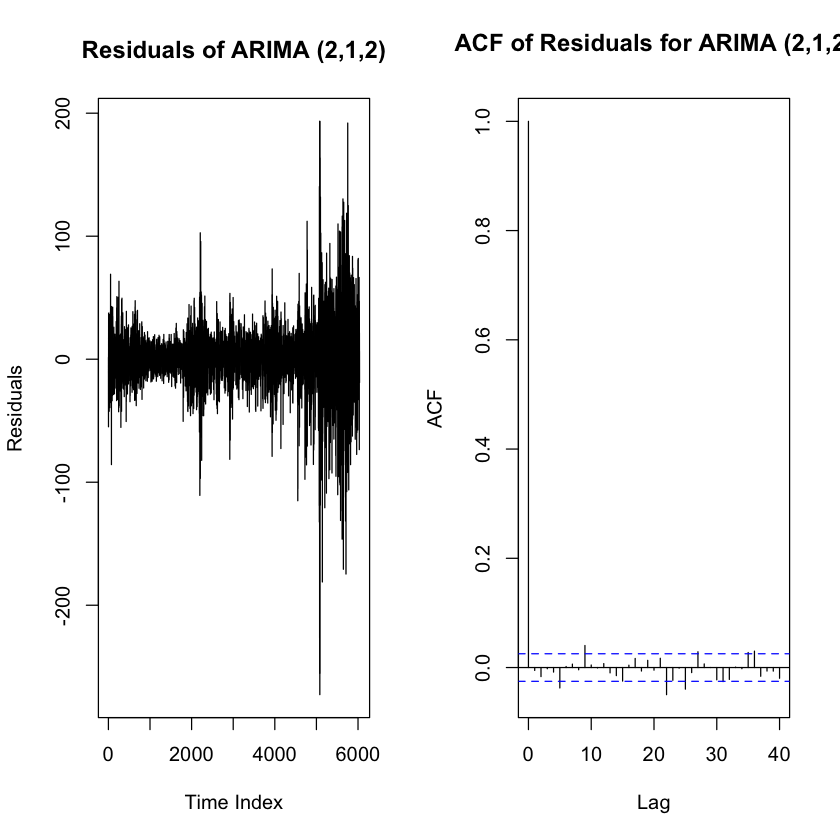

In [45]:
# Step 4: Residual Diagnostics of the Selected ARIMA Model
# Extract residuals from the best model
best_model_residuals <- residuals(best_model)

# Plot residuals and their ACF
# First display the plots in notebook
par(bg = "white", mfrow = c(1, 2))
plot(best_model_residuals, main = paste("Residuals of", best_model_name),
     ylab = "Residuals", xlab = "Time Index")
acf(best_model_residuals, main = paste("ACF of Residuals for", best_model_name),
    lag.max = 40)
par(mfrow = c(1, 1))

# Save plots to file
png("../Reports/Images/Plot5.png", width = 1200, height = 600, res = 150)
par(bg = "white", mfrow = c(1, 2))
plot(best_model_residuals, main = paste("Residuals of", best_model_name),
     ylab = "Residuals", xlab = "Time Index")
acf(best_model_residuals, main = paste("ACF of Residuals for", best_model_name),
    lag.max = 40)
par(mfrow = c(1, 1))
invisible(dev.off())

In [46]:
# Step 5: Ljung-Box Test for Autocorrelation in Residuals
# Perform the Ljung-Box test
lb_test_result <- Box.test(best_model_residuals, lag = 20, type = "Ljung-Box")
print(lb_test_result)

# Interpret the test result
if (lb_test_result$p.value > 0.05) {
  cat("The p-value is greater than 0.05, indicating no significant autocorrelation in residuals.\n") # nolint
} else {
  cat("The p-value is less than or equal to 0.05, indicating significant autocorrelation. Model refinement may be needed.\n") # nolint
}


	Box-Ljung test

data:  best_model_residuals
X-squared = 30.181, df = 20, p-value = 0.06697

The p-value is greater than 0.05, indicating no significant autocorrelation in residuals.


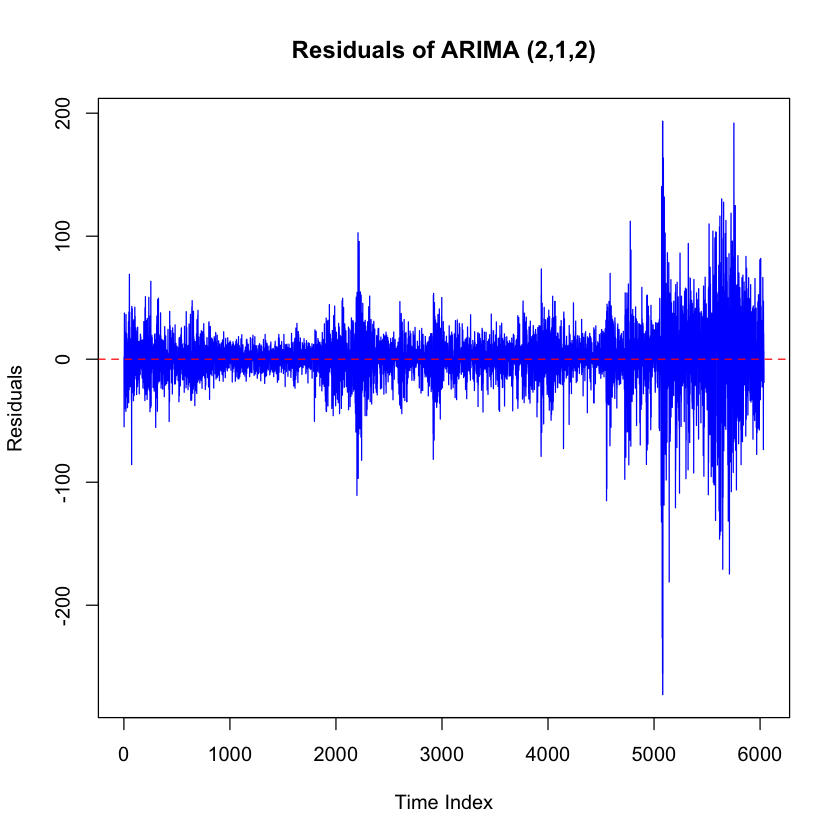

In [47]:
# Residual Diagnostics and Assumption Validation
# Step 1: Plot Residuals of the Selected Model
# Visual inspection of residuals for randomness
# Display plot in notebook
par(bg = "white")
plot(best_model_residuals, main = paste("Residuals of", best_model_name),
     ylab = "Residuals", xlab = "Time Index", col = "blue")
abline(h = 0, col = "red", lty = 2)

# Save plot to file
png("../Reports/Images/Plot6.png", width = 1200, height = 600, res = 150)
par(bg = "white")
plot(best_model_residuals, main = paste("Residuals of", best_model_name),
     ylab = "Residuals", xlab = "Time Index", col = "blue")
abline(h = 0, col = "red", lty = 2)
invisible(dev.off())

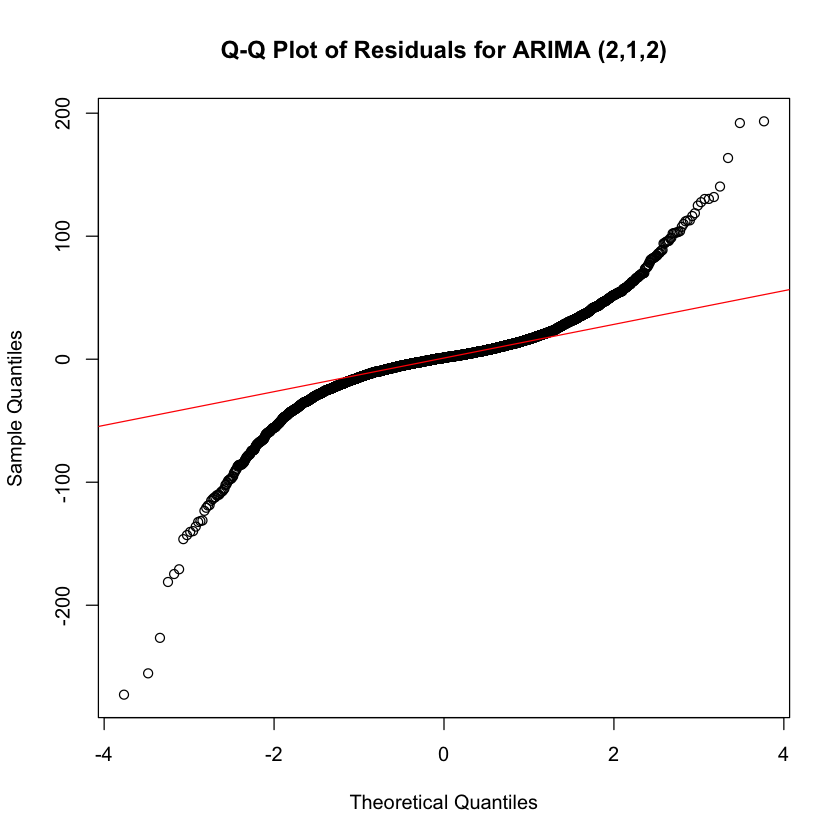

In [48]:
# Step 2: Q-Q Plot to Assess Normality of Residuals
# Display plot in notebook
par(bg = "white")
qqnorm(best_model_residuals, main =
         paste("Q-Q Plot of Residuals for", best_model_name))
qqline(best_model_residuals, col = "red")

# Save plot to file
png("../Reports/Images/Plot7.png", width = 1200, height = 1200, res = 150)
par(bg = "white")
qqnorm(best_model_residuals, main =
         paste("Q-Q Plot of Residuals for", best_model_name))
qqline(best_model_residuals, col = "red")
invisible(dev.off())

In [49]:
# Step 4: Ljung-Box Test for Independence of Residuals
lb_test_result <- Box.test(best_model_residuals, lag = 20, type = "Ljung-Box")
print(lb_test_result)


	Box-Ljung test

data:  best_model_residuals
X-squared = 30.181, df = 20, p-value = 0.06697



In [50]:
# Step 5: Shapiro-Wilk Test for Normality of Residuals
# Sample residuals due to test limitations on sample size
set.seed(123)
sample_residuals <- sample(best_model_residuals, 5000)

# Perform Shapiro-Wilk Test on the sample
shapiro_test_result <- shapiro.test(sample_residuals)
print(shapiro_test_result)


	Shapiro-Wilk normality test

data:  sample_residuals
W = 0.85618, p-value < 2.2e-16



In [51]:
# Model Evaluation and Performance Comparison
# Step 1: Display and Interpret Model Metrics
print(model_metrics)

# Interpretation of the performance metrics
best_model_index <- which.min(model_metrics$AIC)
best_model_name <- model_metrics$Model[best_model_index]
cat("\nThe model with the lowest AIC is:", best_model_name, "\n")

# A tibble: 3 x 5
  Model            AIC    BIC  RMSE Sigma2
  <chr>          <dbl>  <dbl> <dbl>  <dbl>
1 ARIMA (1,2,0) 58571. 58584.  31.0   960.
2 ARIMA (1,1,1) 56067. 56088.  25.2   633.
3 ARIMA (2,1,2) 55940. 55974.  24.9   619.

The model with the lowest AIC is: ARIMA (2,1,2) 


In [52]:
# Step 2: Configure Parallel Processing for Cross-Validation
# Set seed for reproducibility
set.seed(123)
plan(multisession)
num_cores <- parallel::detectCores() - 1
cat("Number of cores available:", num_cores, "\n")
registerDoParallel(cores = num_cores)

# Define cross-validation function
perform_cross_validation <- function(model_order, data, h) {
  # Split data into chunks for parallel processing
  n <- length(data)
  chunk_size <- floor(n / num_cores)

  # Parallel processing of chunks
  results <- foreach(i = 1:num_cores, .combine = c) %dopar% {
    start_idx <- (i - 1) * chunk_size + 1
    end_idx <- min(i * chunk_size, n)
    subset_data <- data[start_idx:end_idx]

    model_func <- function(y, h) {
      fitted_model <- Arima(y, order = model_order)
      forecast(fitted_model, h = h)
    }

    errors <- tsCV(subset_data, model_func, h = h)
    sqrt(mean(errors^2, na.rm = TRUE))
  }

  return(mean(results))
}

Number of cores available: 10 


In [53]:
# Step 3: Execute Cross-Validation for Each Model
# Define model orders to evaluate
model_orders <- list(c(1, 2, 0), c(1, 1, 1), c(2, 1, 2))

# Perform cross-validation for each model
cv_results <- foreach(order = model_orders, .combine = c) %dopar% {
  perform_cross_validation(order, GSPC$GSPC.Adjusted, h = 10)
}

# Update model metrics table with cross-validation results
model_metrics <- model_metrics %>%
  mutate(CV_RMSE = cv_results)

# Display updated model metrics
print(model_metrics)

# Clean up parallel processing
stopImplicitCluster()

# A tibble: 3 x 6
  Model            AIC    BIC  RMSE Sigma2 CV_RMSE
  <chr>          <dbl>  <dbl> <dbl>  <dbl>   <dbl>
1 ARIMA (1,2,0) 58571. 58584.  31.0   960.   108. 
2 ARIMA (1,1,1) 56067. 56088.  25.2   633.    47.2
3 ARIMA (2,1,2) 55940. 55974.  24.9   619.    47.2


In [54]:
# Step 4: Enhanced Rolling Window Cross-Validation
# Set seed and configure parallel processing
set.seed(123)
plan(multisession)
num_cores <- parallel::detectCores() - 1
cat("Number of cores available:", num_cores, "\n")
registerDoParallel(cores = num_cores)

# Define rolling window cross-validation function
rolling_cv <- function(data, window_size, horizon) {
  data_numeric <- as.numeric(data)
  n <- length(data_numeric) - horizon - window_size + 1
  chunk_size <- floor(n / num_cores)

  # Parallel processing of rolling windows
  results <- foreach(i = 1:num_cores, .combine = c) %dopar% { # nolint
    start_idx <- window_size + (i - 1) * chunk_size # nolint
    end_idx <- min(window_size + i * chunk_size - 1, length(data_numeric) - horizon) # nolint
    chunk_errors <- numeric()

    for (j in start_idx:end_idx) {
      train <- data_numeric[1:j]
      test <- data_numeric[(j + 1):(j + horizon)]

      model <- Arima(train, order = c(2, 1, 2)) # nolint
      pred <- forecast(model, h = horizon) # nolint

      pred_means <- as.numeric(pred$mean)
      chunk_errors <- c(chunk_errors, test - pred_means)
    }

    sqrt(mean(chunk_errors^2, na.rm = TRUE))
  }

  return(mean(results))
}

# Apply rolling window cross-validation
cv_horizon <- 12
window_size <- 252  # One trading year
rolling_cv_rmse <- rolling_cv(GSPC$GSPC.Adjusted, window_size, cv_horizon)

# Display cross-validation results
cat("Rolling Window Cross-Validation Results:\n")
cat("Window Size:", window_size, "days (1 trading year)\n")
cat("Forecast Horizon:", cv_horizon, "periods\n")
cat(sprintf("RMSE for %s: %.2f\n", best_model_name, rolling_cv_rmse))

# Clean up parallel processing
stopImplicitCluster()

Number of cores available: 10 
Rolling Window Cross-Validation Results:
Window Size: 252 days (1 trading year)
Forecast Horizon: 12 periods
RMSE for ARIMA (2,1,2): 50.67


In [55]:
# Step 5: Fit Seasonal ARIMA Model if Seasonality Detected
# Attempt to fit a SARIMA model based on seasonal analysis
sarima_model <- auto.arima(GSPC$GSPC.Adjusted, seasonal = TRUE)
summary(sarima_model)

# Extract metrics for the SARIMA model
sarima_metrics <- tibble(
  Model = "SARIMA",
  AIC = AIC(sarima_model),
  BIC = BIC(sarima_model),
  RMSE = sqrt(mean(residuals(sarima_model)^2)),
  Sigma2 = sarima_model$sigma2
)

# Add SARIMA metrics to the model metrics table
model_metrics <- bind_rows(model_metrics, sarima_metrics)
print(model_metrics)

Series: GSPC$GSPC.Adjusted 
ARIMA(1,2,0) 

Coefficients:
          ar1
      -0.5575
s.e.   0.0107

sigma^2 = 959.8:  log likelihood = -29283.46
AIC=58570.92   AICc=58570.93   BIC=58584.33

Training set error measures:
                     ME     RMSE      MAE          MPE     MAPE     MASE
Training set 0.01043789 30.97367 19.28149 -0.000754291 1.035019 1.253051
                   ACF1
Training set -0.1876124

# A tibble: 4 x 6
  Model            AIC    BIC  RMSE Sigma2 CV_RMSE
  <chr>          <dbl>  <dbl> <dbl>  <dbl>   <dbl>
1 ARIMA (1,2,0) 58571. 58584.  31.0   960.   108. 
2 ARIMA (1,1,1) 56067. 56088.  25.2   633.    47.2
3 ARIMA (2,1,2) 55940. 55974.  24.9   619.    47.2
4 SARIMA        58571. 58584.  31.0   960.    NA  


In [56]:
# Step 6: Cross-Validation for SARIMA Model
# Configure parallel processing for SARIMA cross-validation

plan(multisession)
num_cores <- parallel::detectCores() - 1
registerDoParallel(cores = num_cores)

# Define cross-validation function for SARIMA
perform_sarima_cv <- function(data, seasonal_order, h) {
  n <- length(data)
  chunk_size <- floor(n / num_cores)

  results <- foreach(i = 1:num_cores, .combine = c) %dopar% { # nolint
    start_idx <- (i - 1) * chunk_size + 1 # nolint
    end_idx <- min(i * chunk_size, n) # nolint
    subset_data <- data[start_idx:end_idx]

    model_func <- function(y, h) {
      fitted_model <- Arima(y, seasonal = seasonal_order) # nolint
      forecast(fitted_model, h = h) # nolint
    }

    errors <- tsCV(subset_data, model_func, h = h) # nolint
    sqrt(mean(errors^2, na.rm = TRUE))
  }

  return(mean(results))
}

# Execute cross-validation for SARIMA model
seasonal_order <- sarima_model$seasonal$order
sarima_cv_rmse <- perform_sarima_cv(
  GSPC$GSPC.Adjusted,
  seasonal_order = seasonal_order,
  h = 10
)

# Update SARIMA metrics with cross-validation result
sarima_metrics <- sarima_metrics %>%
  mutate(CV_RMSE = sarima_cv_rmse)

# Update model metrics table
model_metrics <- model_metrics %>%
  filter(Model != "SARIMA") %>%
  bind_rows(sarima_metrics)

print(model_metrics)

# Clean up parallel processing
stopImplicitCluster()

# A tibble: 4 x 6
  Model            AIC    BIC  RMSE Sigma2 CV_RMSE
  <chr>          <dbl>  <dbl> <dbl>  <dbl>   <dbl>
1 ARIMA (1,2,0) 58571. 58584.  31.0   960.   108. 
2 ARIMA (1,1,1) 56067. 56088.  25.2   633.    47.2
3 ARIMA (2,1,2) 55940. 55974.  24.9   619.    47.2
4 SARIMA        58571. 58584.  31.0   960.   198. 


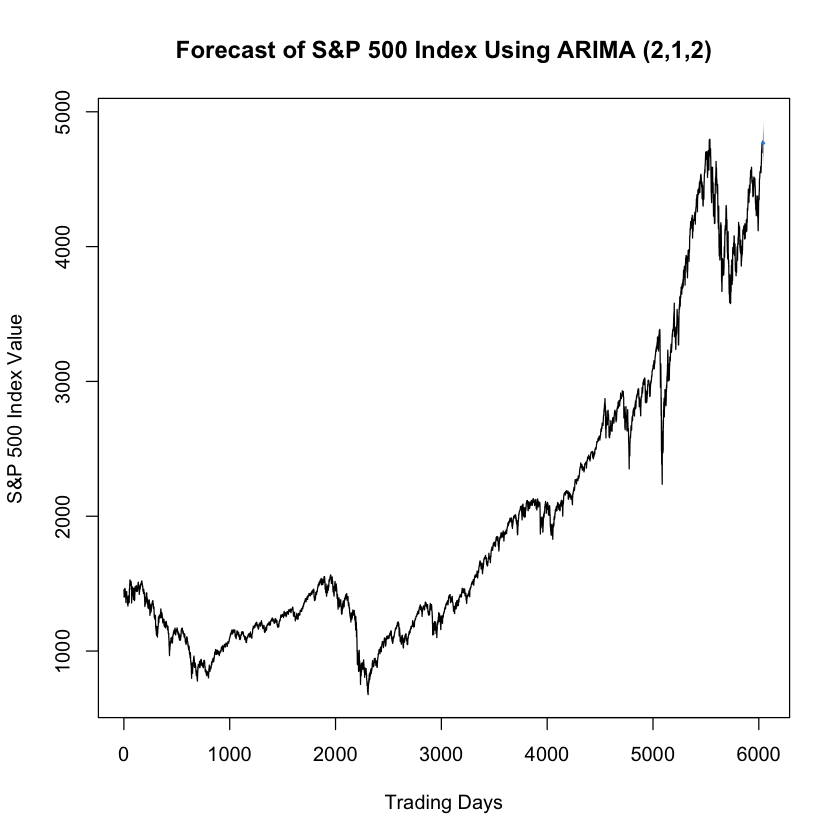

In [57]:
# Step 7: Forecasting Future Values Using the Selected Model
# Forecast the next 12 periods using the best ARIMA model
forecast_horizon <- 12
forecast_result <- forecast(best_model, h = forecast_horizon)

# Display plot in notebook
par(bg = "white")
plot(forecast_result, main =
       paste("Forecast of S&P 500 Index Using", best_model_name),
     xlab = "Trading Days", ylab = "S&P 500 Index Value")

# Save plot to file
png("../Reports/Images/Plot8.png", width = 1200, height = 600, res = 150)
par(bg = "white")
plot(forecast_result, main =
       paste("Forecast of S&P 500 Index Using", best_model_name),
     xlab = "Trading Days", ylab = "S&P 500 Index Value")
invisible(dev.off())